## 1. Setup & Imports

In [32]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import joblib
import json
import time
import os

# ML imports
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    precision_recall_curve, auc
)

# Optional imports
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
    print("XGBoost available")
except ImportError:
    HAS_XGB = False
    print("XGBoost not installed. Use: pip install xgboost")

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    HAS_IMBLEARN = True
    print("imbalanced-learn available")
except ImportError:
    HAS_IMBLEARN = False
    print("imbalanced-learn not installed. Use: pip install imbalanced-learn")

# Plot settings
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("\nAll imports successful!!!")

# Sliding window function for temporal feature extraction
def create_sequences(data, window_size):
    """Create sliding windows from sequential data.
    
    Args:
        data: Array of shape (N, F) where N=samples, F=features
        window_size: Number of consecutive samples per window
        
    Returns:
        Array of shape (N - window_size + 1, window_size * F)
    """
    import numpy as np
    if window_size <= 1:
        return data
    
    n_samples = len(data)
    if n_samples < window_size:
        # Pad with first sample if not enough data
        padding = np.tile(data[0:1], (window_size - n_samples, 1))
        data = np.vstack([padding, data])
        n_samples = len(data)
    
    windows = []
    for i in range(n_samples - window_size + 1):
        window = data[i:i + window_size]
        windows.append(window.flatten())
    
    return np.array(windows)

print("Sliding window function defined")


XGBoost available
imbalanced-learn available

All imports successful!!!
Sliding window function defined


## 2. Configuration

In [33]:
# Paths (adjust for local environment)
DATA_DIR = Path('../data/cicids')
OUTPUT_DIR = Path('../data/models')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Training settings
TEST_SIZE = 0.2       # 20% test
VAL_SIZE = 0.125      # 10% validation (0.125 of 80% = 10% total)
RANDOM_STATE = 42

# Sliding Window Configuration
WINDOW_SIZE = 5  # Number of consecutive flows to combine

# Attack type mapping (CIC-IDS-2017 labels → Attack categories)
ATTACK_MAP = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'DoS' : 'DoS',
    'Port Scan': 'Port Scan',
    'PortScan' : 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# SMOTE/Undersampling settings (adjust based on your class distribution)
SMOTE_TARGETS = {}  # Will be set dynamically
UNDERSAMPLE_BENIGN = 200000

print(f" Data directory: {DATA_DIR}")
print(f" Data directory exists: {DATA_DIR.exists()}")
print(f" Output directory: {OUTPUT_DIR}")

 Data directory: ../data/cicids
 Data directory exists: True
 Output directory: ../data/models


## 3. Load Data

In [34]:
# Find all CSV files
csv_files = sorted(DATA_DIR.glob('*.csv'))
print(f"Found {len(csv_files)} CSV files:")
for f in csv_files:
    print(f"   - {f.name}")

Found 8 CSV files:
   - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
   - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
   - Friday-WorkingHours-Morning.pcap_ISCX.csv
   - Monday-WorkingHours.pcap_ISCX.csv
   - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
   - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
   - Tuesday-WorkingHours.pcap_ISCX.csv
   - Wednesday-workingHours.pcap_ISCX.csv


In [35]:
# Load and combine all CSV files
data_list = []
print("\nData dimensions:")

for i, csv_file in enumerate(csv_files, 1):
    df_temp = pd.read_csv(csv_file, low_memory=False, encoding='utf-8')
    rows, cols = df_temp.shape
    print(f"Data{i} ({csv_file.name}) -> {rows:,} rows, {cols} columns")
    data_list.append(df_temp)

# Concatenate all dataframes
data = pd.concat(data_list, ignore_index=True)
rows, cols = data.shape
print(f"\n Total: {rows:,} rows, {cols} columns")

# Free memory
for d in data_list:
    del d
del data_list

# Clean column names (strip whitespace)
col_names = {col: col.strip() for col in data.columns}
data.rename(columns=col_names, inplace=True)


Data dimensions:
Data1 (Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv) -> 225,745 rows, 79 columns
Data2 (Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv) -> 286,467 rows, 79 columns
Data3 (Friday-WorkingHours-Morning.pcap_ISCX.csv) -> 191,033 rows, 79 columns
Data4 (Monday-WorkingHours.pcap_ISCX.csv) -> 529,918 rows, 79 columns
Data5 (Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv) -> 288,602 rows, 79 columns
Data6 (Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv) -> 170,366 rows, 79 columns
Data7 (Tuesday-WorkingHours.pcap_ISCX.csv) -> 445,909 rows, 79 columns
Data8 (Wednesday-workingHours.pcap_ISCX.csv) -> 692,703 rows, 79 columns

 Total: 2,830,743 rows, 79 columns


In [36]:
# Also load custom labeled data from our network
LABELED_DIR = Path('../data/labeled/flows')

if LABELED_DIR.exists():
    labeled_files = sorted(LABELED_DIR.glob('*.csv'))
    print(f"\n Found {len(labeled_files)} custom labeled files:")
    
    for f in labeled_files:
        try:
            df_custom = pd.read_csv(f, low_memory=False)
            df_custom.columns = df_custom.columns.str.strip()
            
            if 'Label' not in df_custom.columns:
                print(f"    {f.name}: No 'Label' column, skipping")
                continue
            
            # Map our column names to CIC-IDS column names
            # Our flows use lowercase, CIC-IDS uses different format
            COLUMN_MAP = {
                'flow_duration': 'Flow Duration',
                'flow_byts_s': 'Flow Bytes/s',
                'flow_pkts_s': 'Flow Packets/s',
                'fwd_pkts_s': 'Fwd Packets/s',
                'bwd_pkts_s': 'Bwd Packets/s',
                'tot_fwd_pkts': 'Total Fwd Packets',
                'tot_bwd_pkts': 'Total Backward Packets',
                'totlen_fwd_pkts': 'Total Length of Fwd Packets',
                'totlen_bwd_pkts': 'Total Length of Bwd Packets',
                'fwd_pkt_len_max': 'Fwd Packet Length Max',
                'fwd_pkt_len_min': 'Fwd Packet Length Min',
                'fwd_pkt_len_mean': 'Fwd Packet Length Mean',
                'fwd_pkt_len_std': 'Fwd Packet Length Std',
                'bwd_pkt_len_max': 'Bwd Packet Length Max',
                'bwd_pkt_len_min': 'Bwd Packet Length Min',
                'bwd_pkt_len_mean': 'Bwd Packet Length Mean',
                'bwd_pkt_len_std': 'Bwd Packet Length Std',
                'pkt_len_max': 'Max Packet Length',
                'pkt_len_min': 'Min Packet Length',
                'pkt_len_mean': 'Packet Length Mean',
                'pkt_len_std': 'Packet Length Std',
                'pkt_len_var': 'Packet Length Variance',
                'flow_iat_mean': 'Flow IAT Mean',
                'flow_iat_std': 'Flow IAT Std',
                'flow_iat_max': 'Flow IAT Max',
                'flow_iat_min': 'Flow IAT Min',
                'fwd_iat_tot': 'Fwd IAT Total',
                'fwd_iat_mean': 'Fwd IAT Mean',
                'fwd_iat_std': 'Fwd IAT Std',
                'fwd_iat_max': 'Fwd IAT Max',
                'fwd_iat_min': 'Fwd IAT Min',
                'bwd_iat_tot': 'Bwd IAT Total',
                'bwd_iat_mean': 'Bwd IAT Mean',
                'bwd_iat_std': 'Bwd IAT Std',
                'bwd_iat_max': 'Bwd IAT Max',
                'bwd_iat_min': 'Bwd IAT Min',
                'fwd_psh_flags': 'Fwd PSH Flags',
                'bwd_psh_flags': 'Bwd PSH Flags',
                'fwd_urg_flags': 'Fwd URG Flags',
                'bwd_urg_flags': 'Bwd URG Flags',
                'fwd_header_len': 'Fwd Header Length',
                'bwd_header_len': 'Bwd Header Length',
                'fin_flag_cnt': 'FIN Flag Count',
                'syn_flag_cnt': 'SYN Flag Count',
                'rst_flag_cnt': 'RST Flag Count',
                'psh_flag_cnt': 'PSH Flag Count',
                'ack_flag_cnt': 'ACK Flag Count',
                'urg_flag_cnt': 'URG Flag Count',
                'ece_flag_cnt': 'ECE Flag Count',
                'down_up_ratio': 'Down/Up Ratio',
                'pkt_size_avg': 'Average Packet Size',
                'init_fwd_win_byts': 'Init_Win_bytes_forward',
                'init_bwd_win_byts': 'Init_Win_bytes_backward',
                'active_mean': 'Active Mean',
                'active_std': 'Active Std',
                'active_max': 'Active Max',
                'active_min': 'Active Min',
                'idle_mean': 'Idle Mean',
                'idle_std': 'Idle Std',
                'idle_max': 'Idle Max',
                'idle_min': 'Idle Min',
                'fwd_seg_size_avg': 'Avg Fwd Segment Size',
                'bwd_seg_size_avg': 'Avg Bwd Segment Size',
            }
            
            # Rename columns to match CIC-IDS format
            df_custom.rename(columns=COLUMN_MAP, inplace=True)
            
            # Keep only columns that exist in CIC-IDS data
            common_cols = [c for c in df_custom.columns if c in data.columns or c == 'Label']
            df_custom = df_custom[common_cols]
            
            rows = len(df_custom)
            labels = df_custom['Label'].unique()
            print(f"   ✓ {f.name}: {rows} rows, Labels: {list(labels)}")
            
            # Append to main data
            data = pd.concat([data, df_custom], ignore_index=True)
            
        except Exception as e:
            print(f"    {f.name}: Error - {e}")
    
    print(f"\n Total after adding custom data: {len(data):,} rows")
else:
    print(f"\n Custom labeled directory not found: {LABELED_DIR}")


 Found 12 custom labeled files:
   ✓ BENIGN_20251231_160338_flows.csv: 3 rows, Labels: ['BENIGN']
   ✓ BENIGN_20251231_192159_flows.csv: 117 rows, Labels: ['BENIGN']
   ✓ BENIGN_20260102_161038_flows.csv: 451 rows, Labels: ['BENIGN']
   ✓ BENIGN_20260102_161826_flows.csv: 2037 rows, Labels: ['BENIGN']
   ✓ BENIGN_SSH_Firewall_20260102_221903_flows.csv: 2 rows, Labels: ['BENIGN']
   ✓ PORT_SCAN_capture_20260102_224654_flows.csv: 3162 rows, Labels: ['PortScan']
   ✓ PortScan_capture_20260102_224224_flows.csv: 1993 rows, Labels: ['PortScan']
   ✓ PortScan_capture_20260103_092026_flows.csv: 1995 rows, Labels: ['PortScan']
   ✓ Port_Scan_20251231_160217_flows.csv: 3988 rows, Labels: ['Port Scan']
   ✓ Port_Scan_20260102_155825_flows.csv: 8192 rows, Labels: ['PortScan']
   ✓ SSH_Normal_20260101_171514_flows.csv: 220 rows, Labels: ['BENIGN']
   ✓ merged_benign_flows_20260102_224256.csv: 6911 rows, Labels: ['BENIGN']

 Total after adding custom data: 2,859,814 rows


## 4. Data Overview

In [37]:
print(" Column names:")
print(data.columns.tolist())

 Column names:
['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2859814 entries, 0 to 2859813
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             float64
 1   Flow Duration                float64
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 float64
 19  

In [39]:
pd.options.display.max_rows = 80
print('Overview of Columns:')
data.describe()

Overview of Columns:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.859814e+06,2.859814e+06,2.859814e+06,2.859814e+06,2.859814e+06,2.859814e+06,2.859814e+06,2.859814e+06,2.859814e+06,...,2.830743e+06,2.830743e+06,2.859814e+06,2.859814e+06,2.859814e+06,2.859814e+06,2.859814e+06,2.859814e+06,2.859814e+06,2.859814e+06
mean,8.071483e+03,1.463536e+07,9.475811e+00,1.064486e+01,6.328795e+02,1.645900e+04,2.078012e+02,1.920182e+01,5.864381e+01,6.868928e+01,...,5.418218e+00,-2.741688e+03,8.072232e+04,4.071597e+04,1.516254e+05,5.770322e+04,8.231501e+06,4.987222e+05,8.607357e+06,7.839521e+06
std,1.828363e+04,3.351509e+07,7.469832e+02,9.977897e+02,2.734008e+04,2.256756e+06,7.147974e+02,6.030579e+01,1.856836e+02,2.800801e+02,...,6.364257e+02,1.084989e+06,6.453467e+05,3.913987e+05,1.020713e+06,5.741814e+05,2.352446e+07,4.579808e+06,2.425841e+07,2.325794e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.470000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.113900e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.220000e+02,3.700000e+01,2.000000e+00,3.440000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,2.991949e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.790000e+02,8.000000e+01,3.700000e+01,5.100000e+01,2.519524e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [40]:
# Label distribution
print("\n Original Label Distribution:")
print(data['Label'].value_counts())


 Original Label Distribution:
Label
BENIGN                        2282838
DoS Hulk                       231073
PortScan                       174272
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Port Scan                        3988
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


## 5. Pre-processing

### 5.1 Clean Data

In [41]:
# Duplicate values
dups = data[data.duplicated()]
print(f"Number of duplicates: {len(dups):,}")
data.drop_duplicates(inplace=True)
print(f"After removing duplicates: {len(data):,} rows")

# Missing values - replace inf with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Print missing values
missing = data.isna().sum()
print("\nMissing values:")
print(missing.loc[missing > 0])

# Fill missing values with median
for col in data.select_dtypes(include=[np.number]).columns:
    if data[col].isna().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)

print(f"\n Missing values handled")

Number of duplicates: 329,826
After removing duplicates: 2,529,988 rows

Missing values:
Destination Port        7626
Flow Bytes/s            1564
Flow Packets/s          1564
CWE Flag Count          7626
Fwd Header Length.1     7626
Fwd Avg Bytes/Bulk      7626
Fwd Avg Packets/Bulk    7626
Fwd Avg Bulk Rate       7626
Bwd Avg Bytes/Bulk      7626
Bwd Avg Packets/Bulk    7626
Bwd Avg Bulk Rate       7626
Subflow Fwd Packets     7626
Subflow Fwd Bytes       7626
Subflow Bwd Packets     7626
Subflow Bwd Bytes       7626
act_data_pkt_fwd        7626
min_seg_size_forward    7626
dtype: int64

 Missing values handled


### 5.2 Map Attack Types

In [42]:
# Create Attack Type column from Label
data['Attack Type'] = data['Label'].map(ATTACK_MAP)

# Handle unmapped labels
unmapped = data[data['Attack Type'].isna()]['Label'].unique()
if len(unmapped) > 0:
    print(f" Unmapped labels: {unmapped}")
    # Map any remaining attack labels
    data['Attack Type'] = data['Attack Type'].fillna('Unknown')

print("\n Attack Type Distribution:")
print(data['Attack Type'].value_counts())


 Attack Type Distribution:
Attack Type
BENIGN          2104051
DoS              193748
DDoS             128016
Port Scan         90878
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64


In [43]:
# Drop attack types with too few samples (< 1000)
type_counts = data['Attack Type'].value_counts()
types_to_drop = type_counts[type_counts < 1000].index
if len(types_to_drop) > 0:
    print(f" Dropping attack types with < 1000 samples: {list(types_to_drop)}")
    data = data[~data['Attack Type'].isin(types_to_drop)]

print("\n Final Attack Type Distribution:")
print(data['Attack Type'].value_counts())

 Dropping attack types with < 1000 samples: ['Infiltration', 'Heartbleed']

 Final Attack Type Distribution:
Attack Type
BENIGN         2104051
DoS             193748
DDoS            128016
Port Scan        90878
Brute Force       9152
Web Attack        2143
Bot               1953
Name: count, dtype: int64


In [44]:
# Encode Attack Type to Attack Number
le = LabelEncoder()
data['Attack Number'] = le.fit_transform(data['Attack Type'])

# Print mapping
print("\n Attack Type Encoding:")
attack_mapping = {}
for val in sorted(data['Attack Number'].unique()):
    attack_name = le.inverse_transform([val])[0]
    attack_mapping[val] = attack_name
    print(f"   {val}: {attack_name}")

# Save mapping for later use
target_names = [attack_mapping[i] for i in sorted(attack_mapping.keys())]


 Attack Type Encoding:
   0: BENIGN
   1: Bot
   2: Brute Force
   3: DDoS
   4: DoS
   5: Port Scan
   6: Web Attack


### 5.3 Feature Selection

In [45]:
# Remove columns with zero standard deviation
std = data.std(numeric_only=True)
zero_std_cols = std[std == 0].index.tolist()

if len(zero_std_cols) > 0:
    print(f"Dropping columns with zero std: {zero_std_cols}")
    data.drop(columns=zero_std_cols, inplace=True)

Dropping columns with zero std: ['Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


In [46]:
# Feature selection: Keep features with significant correlation (positive OR negative)
corr = data.corr(numeric_only=True).round(2)

# Get absolute correlation and filter by threshold
MIN_CORRELATION = 0.01  # Minimum |correlation| to keep feature
abs_corr = corr['Attack Number'].abs()

# Select features with |correlation| > threshold (excluding perfect correlation = 1)
significant_features = abs_corr[
    (abs_corr > MIN_CORRELATION) & (abs_corr < 1)
].index.tolist()

print(f"\nFeatures with |correlation| > {MIN_CORRELATION} with 'Attack Number': {len(significant_features)}")
print("\nPositive correlations:")
pos_features = corr['Attack Number'][(corr['Attack Number'] > MIN_CORRELATION) & (corr['Attack Number'] < 1)]
for i, (feature, corr_val) in enumerate(pos_features.sort_values(ascending=False).items(), 1):
    print(f'  {i:>2}. {feature:<35}: +{corr_val}')

print("\nNegative correlations:")
neg_features = corr['Attack Number'][(corr['Attack Number'] < -MIN_CORRELATION) & (corr['Attack Number'] > -1)]
for i, (feature, corr_val) in enumerate(neg_features.sort_values().items(), 1):
    print(f'  {i:>2}. {feature:<35}: {corr_val}')

# Keep all significantly correlated features
valid_columns = significant_features + ['Attack Number', 'Attack Type']
data = data[[col for col in data.columns if col in valid_columns]]

print(f"\n Kept {len(significant_features)} features (positive: {len(pos_features)}, negative: {len(neg_features)})")


Features with |correlation| > 0.01 with 'Attack Number': 48

Positive correlations:
   1. Bwd Packet Length Std              : +0.54
   2. Bwd Packet Length Mean             : +0.53
   3. Avg Bwd Segment Size               : +0.53
   4. Bwd Packet Length Max              : +0.53
   5. Fwd IAT Std                        : +0.5
   6. Packet Length Std                  : +0.5
   7. Max Packet Length                  : +0.49
   8. Idle Max                           : +0.47
   9. Idle Min                           : +0.46
  10. Flow IAT Max                       : +0.46
  11. Idle Mean                          : +0.46
  12. Fwd IAT Max                        : +0.46
  13. Packet Length Variance             : +0.46
  14. Average Packet Size                : +0.45
  15. Packet Length Mean                 : +0.45
  16. Flow IAT Std                       : +0.4
  17. Flow Duration                      : +0.27
  18. Fwd IAT Total                      : +0.27
  19. FIN Flag Count                

### 5.4 Optimize Memory

In [47]:
# Downcast to reduce memory
old_memory = data.memory_usage().sum() / 1024**2
print(f'Initial memory usage: {old_memory:.2f} MB')

for col in data.columns:
    col_type = data[col].dtype
    if col_type != object:
        c_min = data[col].min()
        c_max = data[col].max()
        # Downcast float64 to float32
        if str(col_type).find('float') >= 0:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                data[col] = data[col].astype(np.float32)
        # Downcast int64 to int32
        elif str(col_type).find('int') >= 0:
            if c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                data[col] = data[col].astype(np.int32)

new_memory = data.memory_usage().sum() / 1024**2
print(f'Final memory usage: {new_memory:.2f} MB')
print(f'Reduction: {100 * (1 - new_memory / old_memory):.1f}%')

Initial memory usage: 984.40 MB


Final memory usage: 511.50 MB
Reduction: 48.0%


In [48]:
# Final data overview
print("\n📊 Final Data:")
data.info()


📊 Final Data:
<class 'pandas.core.frame.DataFrame'>
Index: 2529941 entries, 0 to 2859813
Data columns (total 50 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Destination Port         float32
 1   Flow Duration            float32
 2   Fwd Packet Length Max    int32  
 3   Fwd Packet Length Min    int32  
 4   Fwd Packet Length Mean   float32
 5   Fwd Packet Length Std    float32
 6   Bwd Packet Length Max    int32  
 7   Bwd Packet Length Min    int32  
 8   Bwd Packet Length Mean   float32
 9   Bwd Packet Length Std    float32
 10  Flow Bytes/s             float32
 11  Flow Packets/s           float32
 12  Flow IAT Mean            float32
 13  Flow IAT Std             float32
 14  Flow IAT Max             float32
 15  Flow IAT Min             float32
 16  Fwd IAT Total            float32
 17  Fwd IAT Mean             float32
 18  Fwd IAT Std              float32
 19  Fwd IAT Max              float32
 20  Fwd IAT Min              float32
 21

## 6. Features & Labels

In [49]:
# Extract features and labels
features = [col for col in data.columns if col not in ['Attack Type', 'Attack Number', 'Label']]
X = data[features]
y = data['Attack Number']

print(f"Features: {len(features)}")
print(f"Samples: {len(X):,}")
print(f"Classes: {len(y.unique())}")

# Feature columns for later use
feature_columns = features.copy()

Features: 48
Samples: 2,529,941
Classes: 7


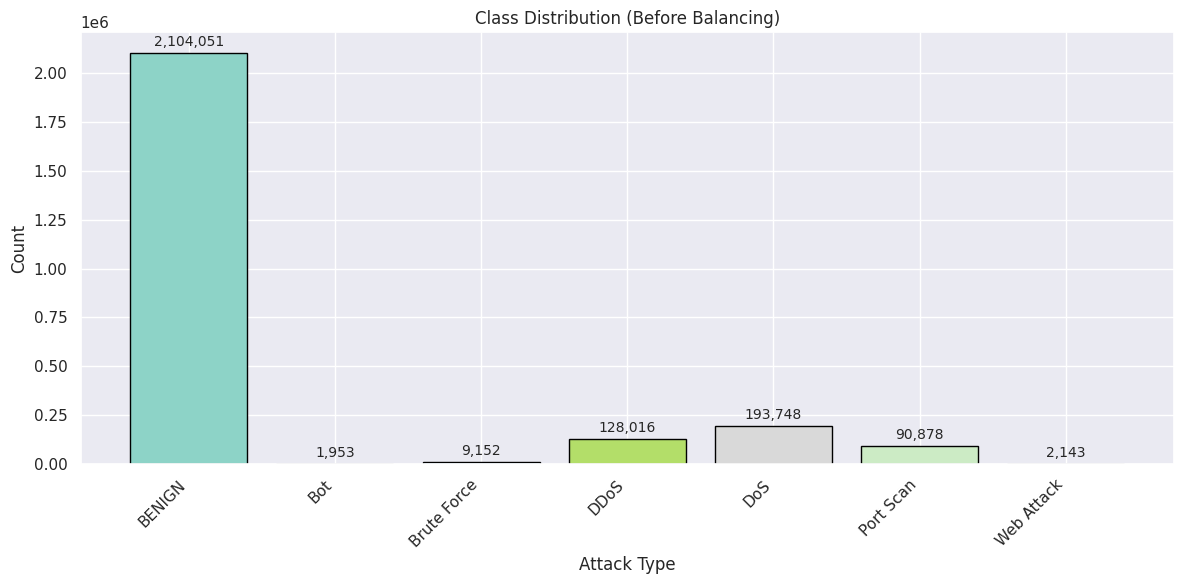

In [50]:
# Visualize class distribution
fig, ax = plt.subplots(figsize=(12, 6))

class_counts = y.value_counts().sort_index()
colors = plt.cm.Set3(np.linspace(0, 1, len(class_counts)))

bars = ax.bar([attack_mapping[i] for i in class_counts.index], 
              class_counts.values, color=colors, edgecolor='black')

for bar, count in zip(bars, class_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(class_counts)*0.01,
            f'{count:,}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Attack Type')
ax.set_ylabel('Count')
ax.set_title('Class Distribution (Before Balancing)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 7. Data Split

In [51]:
# Split: 70% train, 10% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=VAL_SIZE, stratify=y_temp, random_state=RANDOM_STATE
)

print(f"📂 Data Split:")
print(f"   Train:      {len(X_train):,} samples ({len(X_train)/len(X):.1%})")
print(f"   Validation: {len(X_val):,} samples ({len(X_val)/len(X):.1%})")
print(f"   Test:       {len(X_test):,} samples ({len(X_test)/len(X):.1%})")

📂 Data Split:
   Train:      1,770,958 samples (70.0%)
   Validation: 252,994 samples (10.0%)
   Test:       505,989 samples (20.0%)


## 8. Class Balancing

In [52]:
if HAS_IMBLEARN:
    # Check class distribution
    train_class_dist = y_train.value_counts().sort_index()
    print("Training set class distribution before balancing:")
    for attack_num, count in train_class_dist.items():
        print(f"   {attack_mapping[attack_num]}: {count:,}")
    
    # Determine which classes need SMOTE (minority classes < 10000)
    minority_classes = train_class_dist[train_class_dist < 10000].index.tolist()
    smote_targets = {cls: 10000 for cls in minority_classes if cls != 0}  # Don't SMOTE BENIGN
    
    print(f"\nSMOTE targets: {smote_targets}")
    
    # Apply SMOTE
    if smote_targets:
        smote = SMOTE(
            sampling_strategy=smote_targets,
            random_state=RANDOM_STATE,
            k_neighbors=3
        )
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        print(f"   After SMOTE: {len(X_train_balanced):,} samples")
    else:
        X_train_balanced, y_train_balanced = X_train, y_train
    
    # Apply undersampling to BENIGN (class 0)
    benign_count = (y_train_balanced == 0).sum()
    if benign_count > UNDERSAMPLE_BENIGN:
        under = RandomUnderSampler(
            sampling_strategy={0: UNDERSAMPLE_BENIGN},
            random_state=RANDOM_STATE
        )
        X_train_balanced, y_train_balanced = under.fit_resample(X_train_balanced, y_train_balanced)
        print(f"   After undersampling BENIGN: {len(X_train_balanced):,} samples")
    
    # Shuffle
    shuffle_idx = np.random.permutation(len(y_train_balanced))
    X_train_balanced = X_train_balanced.iloc[shuffle_idx].reset_index(drop=True)
    y_train_balanced = y_train_balanced.iloc[shuffle_idx].reset_index(drop=True)
    
    print("\nTraining set class distribution after balancing:")
    balanced_dist = y_train_balanced.value_counts().sort_index()
    for attack_num, count in balanced_dist.items():
        print(f"   {attack_mapping[attack_num]}: {count:,}")
else:
    print("imbalanced-learn not available. Using unbalanced data.")
    X_train_balanced = X_train
    y_train_balanced = y_train

Training set class distribution before balancing:
   BENIGN: 1,472,835
   Bot: 1,368
   Brute Force: 6,407
   DDoS: 89,611
   DoS: 135,623
   Port Scan: 63,614
   Web Attack: 1,500

SMOTE targets: {1: 10000, 2: 10000, 6: 10000}
   After SMOTE: 1,791,683 samples
   After undersampling BENIGN: 518,848 samples

Training set class distribution after balancing:
   BENIGN: 200,000
   Bot: 10,000
   Brute Force: 10,000
   DDoS: 89,611
   DoS: 135,623
   Port Scan: 63,614
   Web Attack: 10,000


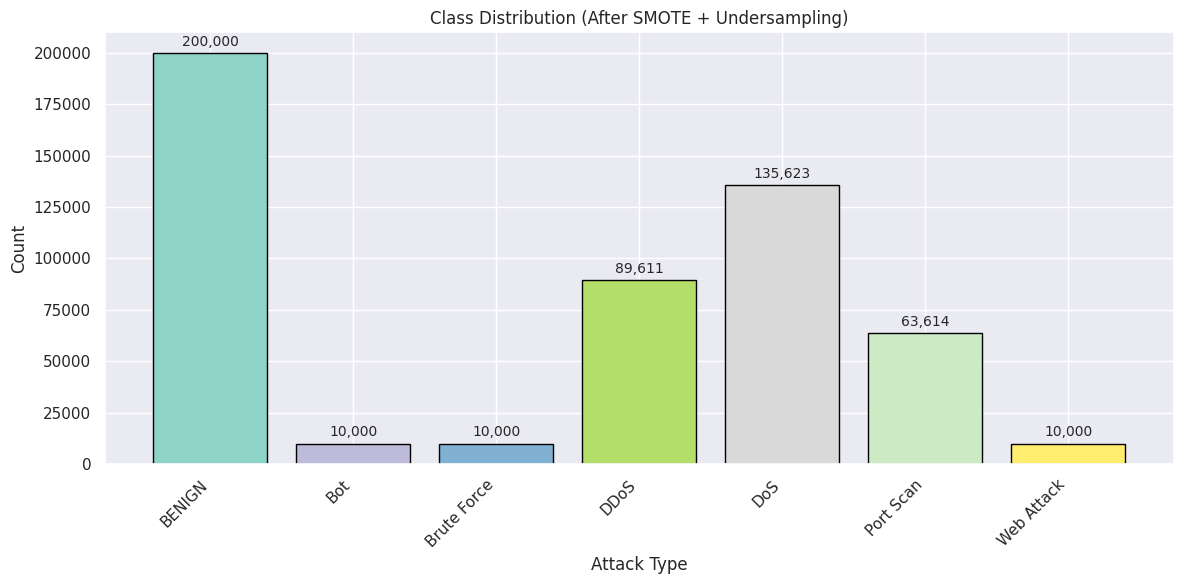

In [53]:
# Visualize balanced distribution
fig, ax = plt.subplots(figsize=(12, 6))

balanced_counts = y_train_balanced.value_counts().sort_index()
colors = plt.cm.Set3(np.linspace(0, 1, len(balanced_counts)))

bars = ax.bar([attack_mapping[i] for i in balanced_counts.index], 
              balanced_counts.values, color=colors, edgecolor='black')

for bar, count in zip(bars, balanced_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(balanced_counts)*0.01,
            f'{count:,}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Attack Type')
ax.set_ylabel('Count')
ax.set_title('Class Distribution (After SMOTE + Undersampling)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 9. Scaling

In [54]:
# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("StandardScaler applied")
print(f"   Train mean: {X_train_scaled.mean():.6f}")
print(f"   Train std:  {X_train_scaled.std():.6f}")

# Apply sliding window to capture temporal patterns
print(f"\nApplying sliding window (size={WINDOW_SIZE})...")
print(f"   Before windowing: X_train={X_train_scaled.shape}")

X_train_windowed = create_sequences(X_train_scaled, WINDOW_SIZE)
X_val_windowed = create_sequences(X_val_scaled, WINDOW_SIZE)
X_test_windowed = create_sequences(X_test_scaled, WINDOW_SIZE)

# Adjust labels to match windowed samples (use last label in each window)
if WINDOW_SIZE > 1:
    y_train_windowed = y_train_balanced[WINDOW_SIZE-1:]
    y_val_windowed = y_val[WINDOW_SIZE-1:]
    y_test_windowed = y_test[WINDOW_SIZE-1:]
else:
    y_train_windowed = y_train_balanced
    y_val_windowed = y_val
    y_test_windowed = y_test

print(f"   After windowing: X_train={X_train_windowed.shape}")
print(f"   Window creates {X_train_windowed.shape[1]} features from {X_train_scaled.shape[1]} original features x {WINDOW_SIZE} windows")


StandardScaler applied
   Train mean: -0.000000
   Train std:  1.000000

Applying sliding window (size=5)...
   Before windowing: X_train=(518848, 48)
   After windowing: X_train=(518844, 240)
   Window creates 240 features from 48 original features x 5 windows


## 10. Model Training

In [55]:
# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10,
        max_features='sqrt',
        random_state=RANDOM_STATE
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        max_features='sqrt',
        n_jobs=-1,
        random_state=RANDOM_STATE
    ),
}

if HAS_XGB:
    models['XGBoost'] = XGBClassifier(
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0
    )

print(f"Models to train: {list(models.keys())}")

Models to train: ['Decision Tree', 'Random Forest', 'XGBoost']


In [56]:
# Train all models
trained_models = {}
training_times = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    model.fit(X_train_windowed, y_train_windowed)
    
    elapsed = time.time() - start_time
    training_times[name] = elapsed
    trained_models[name] = model
    
    print(f"   Completed in {elapsed:.1f}s")

print(f"\n All {len(trained_models)} models trained!")


Training Decision Tree...
   Completed in 6.9s

Training Random Forest...
   Completed in 98.6s

Training XGBoost...
   Completed in 141.6s

 All 3 models trained!


## 11. Evaluation

In [57]:
def compute_pr_auc(y_true, y_pred_proba, n_classes):
    """Compute average PR-AUC across all classes"""
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    pr_auc_scores = []
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
        pr_auc = auc(recall, precision)
        pr_auc_scores.append(pr_auc)
    return np.mean(pr_auc_scores)


def evaluate_model(model, X, y, model_name):
    """Full model evaluation"""
    y_pred = model.predict(X)
    n_classes = len(np.unique(y))
    
    results = {
        'model_name': model_name,
        'accuracy': accuracy_score(y, y_pred),
        'precision_macro': precision_score(y, y_pred, average='macro', zero_division=0),
        'precision_weighted': precision_score(y, y_pred, average='weighted', zero_division=0),
        'recall_macro': recall_score(y, y_pred, average='macro', zero_division=0),
        'recall_weighted': recall_score(y, y_pred, average='weighted', zero_division=0),
        'f1_macro': f1_score(y, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y, y_pred, average='weighted', zero_division=0),
        'confusion_matrix': confusion_matrix(y, y_pred),
        'classification_report': classification_report(y, y_pred, target_names=target_names, output_dict=True),
        'y_pred': y_pred,
    }
    
    # PR-AUC
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X)
        results['pr_auc'] = compute_pr_auc(y, y_prob, n_classes)
        results['y_prob'] = y_prob
    
    return results

In [59]:
# Evaluate all models on test set
all_results = {}

for name, model in trained_models.items():
    print(f"\nEvaluating {name}...")
    results = evaluate_model(model, X_test_windowed, y_test_windowed, name)
    all_results[name] = results
    
    print(f"   Accuracy:      {results['accuracy']:.4f}")
    print(f"   F1 (macro):    {results['f1_macro']:.4f}")
    print(f"   F1 (weighted): {results['f1_weighted']:.4f}")
    if 'pr_auc' in results:
        print(f"   PR-AUC:        {results['pr_auc']:.4f}")


Evaluating Decision Tree...
   Accuracy:      0.9719
   F1 (macro):    0.7734
   F1 (weighted): 0.9758
   PR-AUC:        0.7795

Evaluating Random Forest...
   Accuracy:      0.9893
   F1 (macro):    0.8062
   F1 (weighted): 0.9916
   PR-AUC:        0.9123

Evaluating XGBoost...
   Accuracy:      0.9959
   F1 (macro):    0.9118
   F1 (weighted): 0.9964
   PR-AUC:        0.9607


## 12. Comparison

In [60]:
# Create comparison DataFrame
comparison_data = []
for name, results in all_results.items():
    row = {
        'Model': name,
        'Accuracy': results['accuracy'],
        'Precision (macro)': results['precision_macro'],
        'Recall (macro)': results['recall_macro'],
        'F1 (macro)': results['f1_macro'],
        'F1 (weighted)': results['f1_weighted'],
        'Training Time (s)': training_times[name],
    }
    if 'pr_auc' in results:
        row['PR-AUC'] = results['pr_auc']
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')
print("\nModel Comparison:")
comparison_df


Model Comparison:


,Accuracy,Precision (macro),Recall (macro),F1 (macro),F1 (weighted),Training Time (s),PR-AUC
Model,,,,,,,
Decision Tree,0.971944,0.744327,0.900875,0.773386,0.975831,6.864346,0.779529
Random Forest,0.989348,0.775008,0.942464,0.806164,0.991597,98.624557,0.912268
XGBoost,0.995909,0.883304,0.995930,0.911823,0.996438,141.576632,0.960715


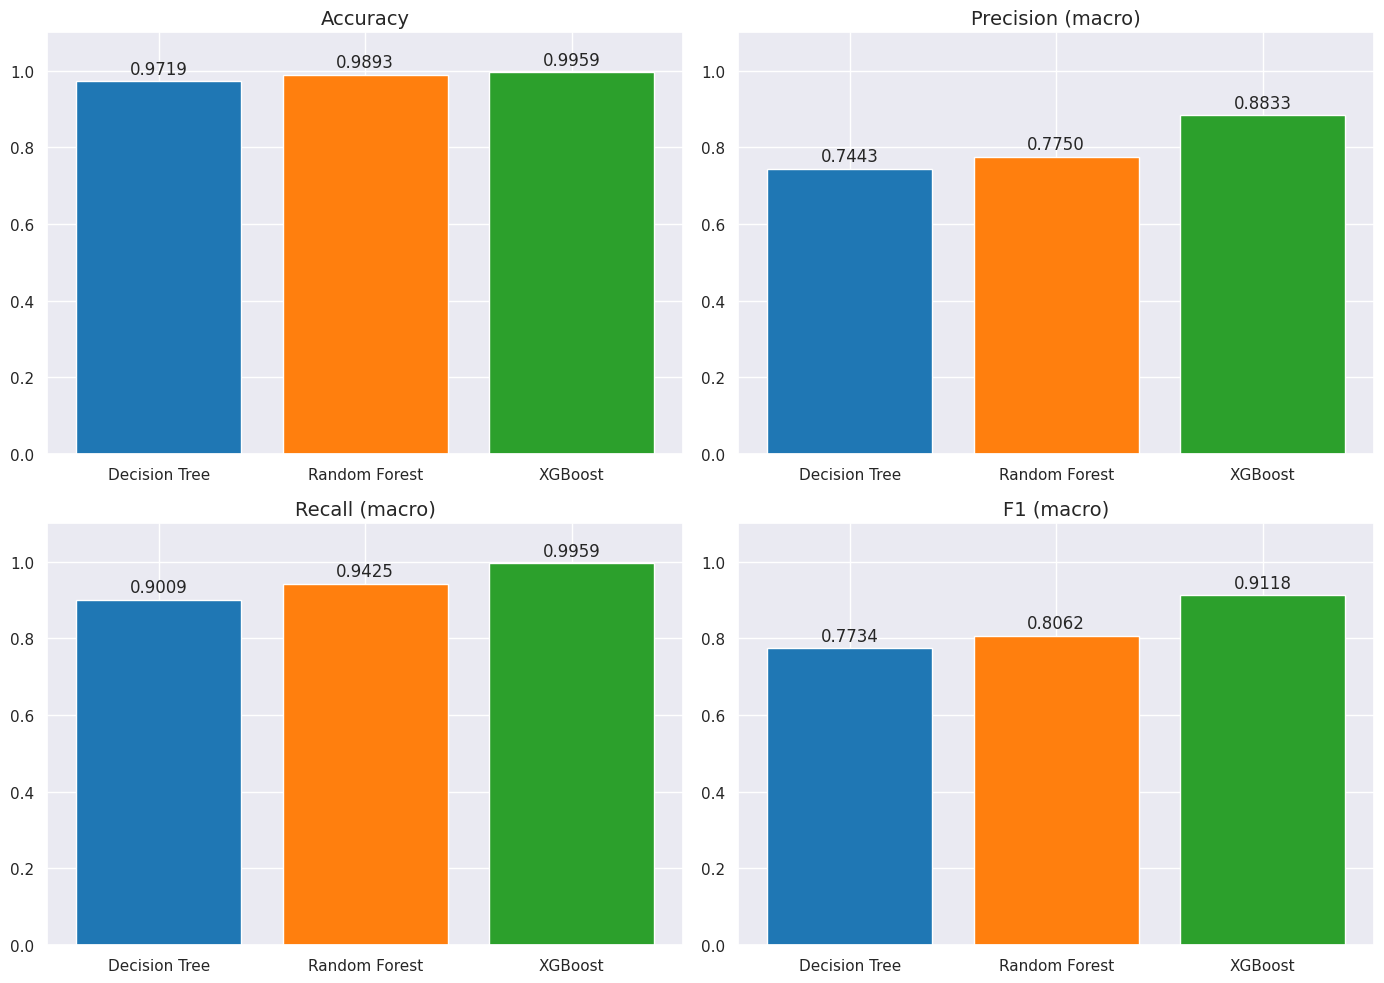

In [61]:
# Plot comparison
metrics = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1 (macro)']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df.index, values, color=colors[:len(values)])
    ax.set_title(metric, fontsize=14)
    ax.set_ylim(0, 1.1)
    for bar, v in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, v + 0.02, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

## 13. Confusion Matrix

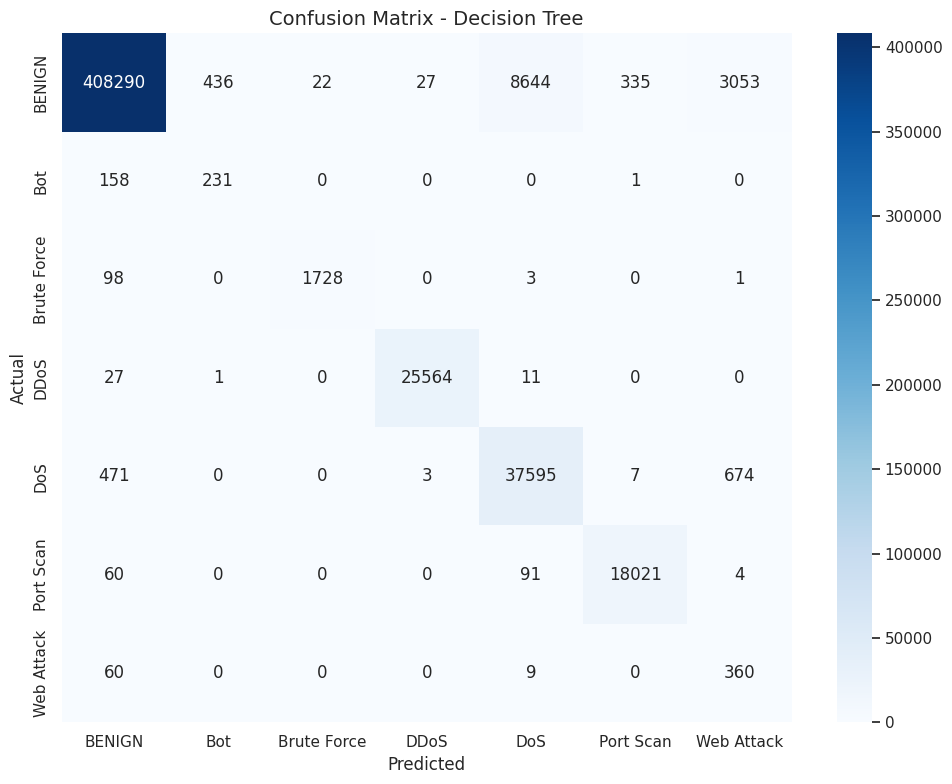

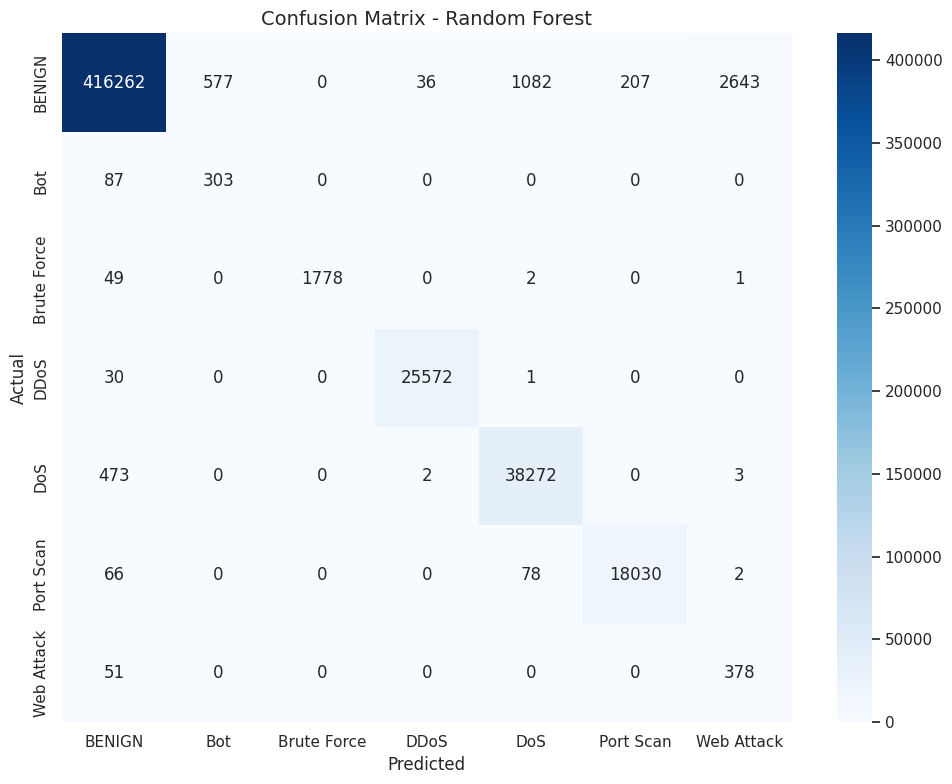

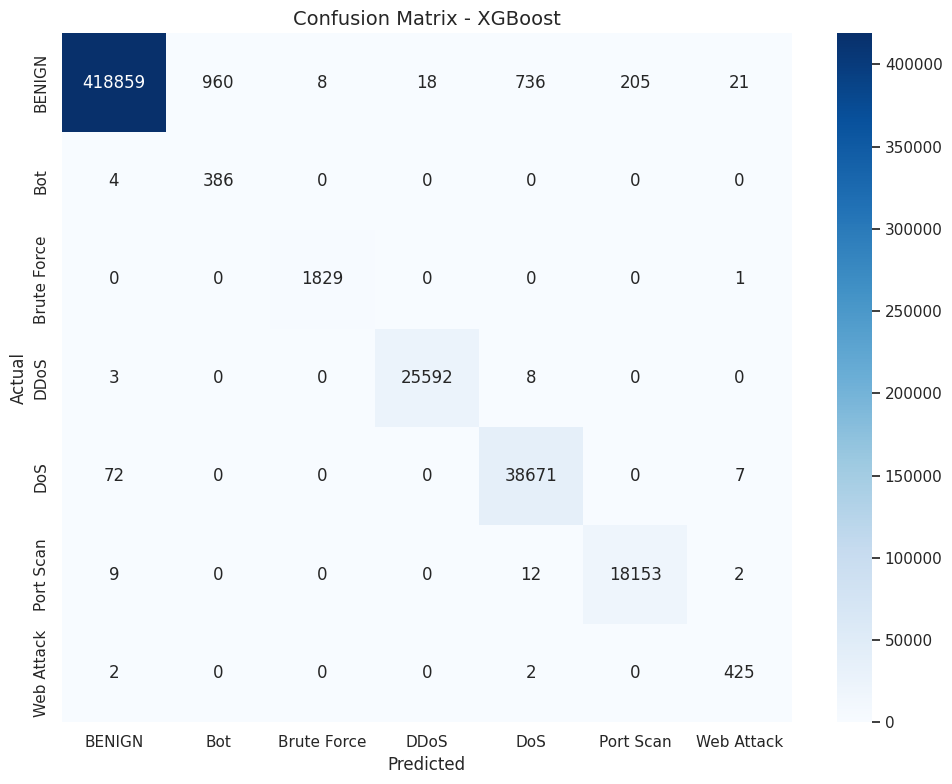

In [62]:
# Plot confusion matrices
for name, results in all_results.items():
    cm = results['confusion_matrix']
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {name}', fontsize=14)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

## 14. Classification Report

In [63]:
# Print classification reports
for name, results in all_results.items():
    print(f"\n{'='*60}")
    print(f" {name} - Classification Report")
    print('='*60)
    print(classification_report(y_test_windowed, results['y_pred'], target_names=target_names))


 Decision Tree - Classification Report
              precision    recall  f1-score   support

      BENIGN       1.00      0.97      0.98    420807
         Bot       0.35      0.59      0.44       390
 Brute Force       0.99      0.94      0.97      1830
        DDoS       1.00      1.00      1.00     25603
         DoS       0.81      0.97      0.88     38750
   Port Scan       0.98      0.99      0.99     18176
  Web Attack       0.09      0.84      0.16       429

    accuracy                           0.97    505985
   macro avg       0.74      0.90      0.77    505985
weighted avg       0.98      0.97      0.98    505985


 Random Forest - Classification Report
              precision    recall  f1-score   support

      BENIGN       1.00      0.99      0.99    420807
         Bot       0.34      0.78      0.48       390
 Brute Force       1.00      0.97      0.99      1830
        DDoS       1.00      1.00      1.00     25603
         DoS       0.97      0.99      0.98     3875

## 15. Per-Class Metrics

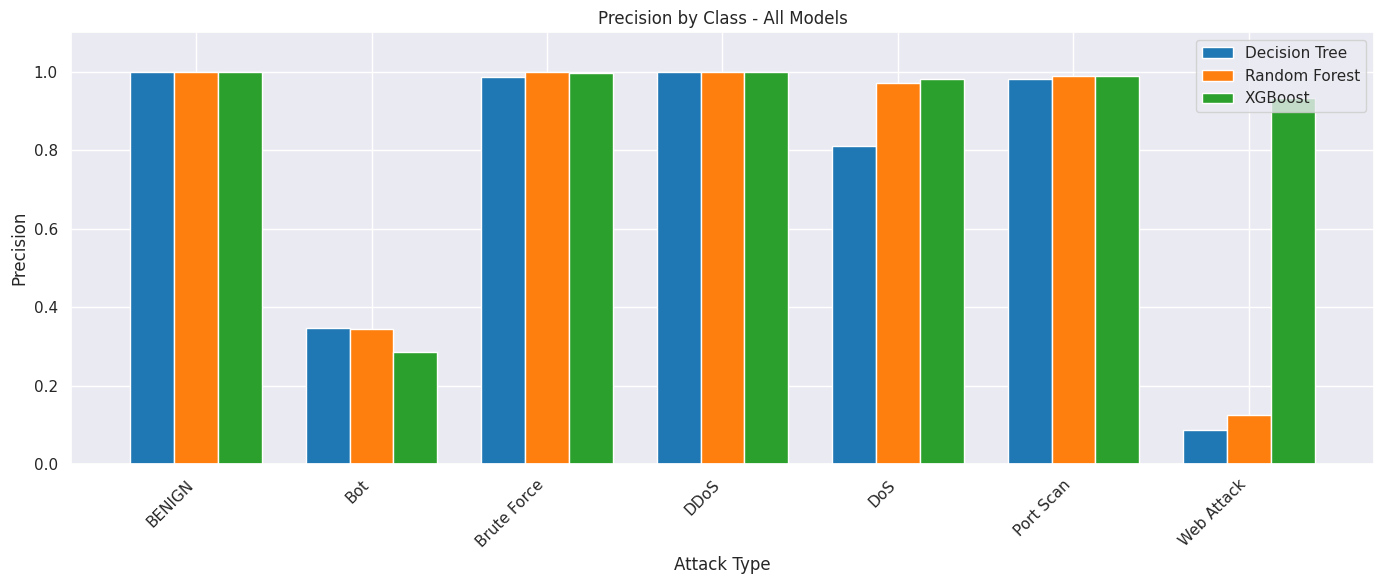

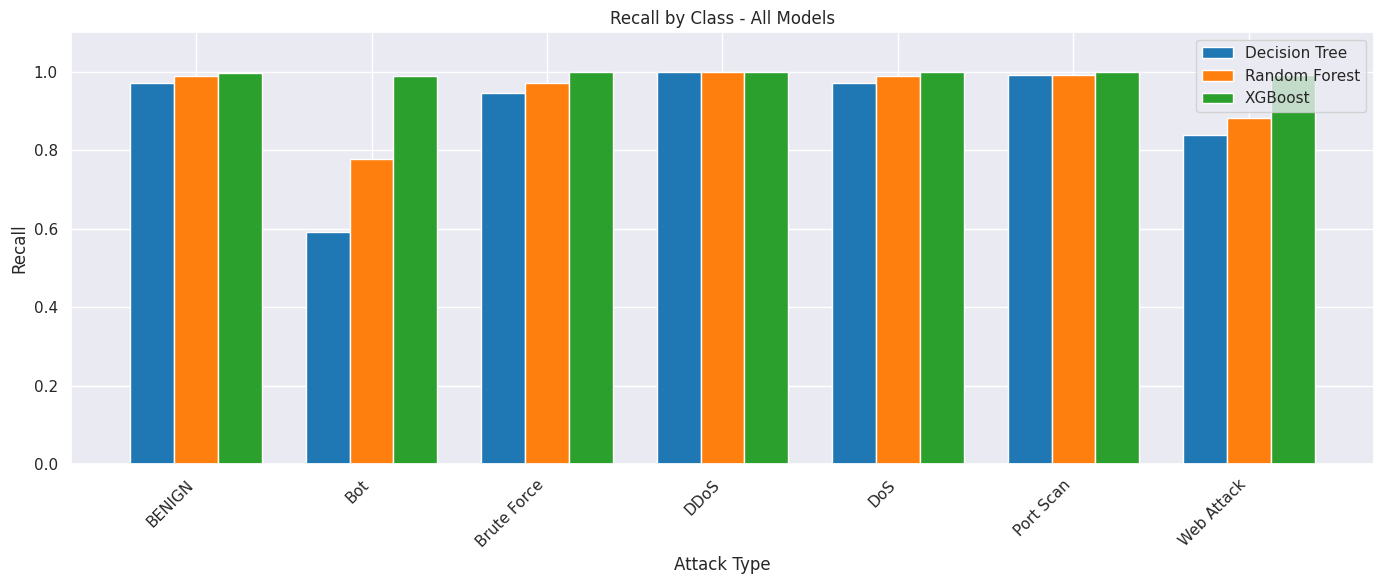

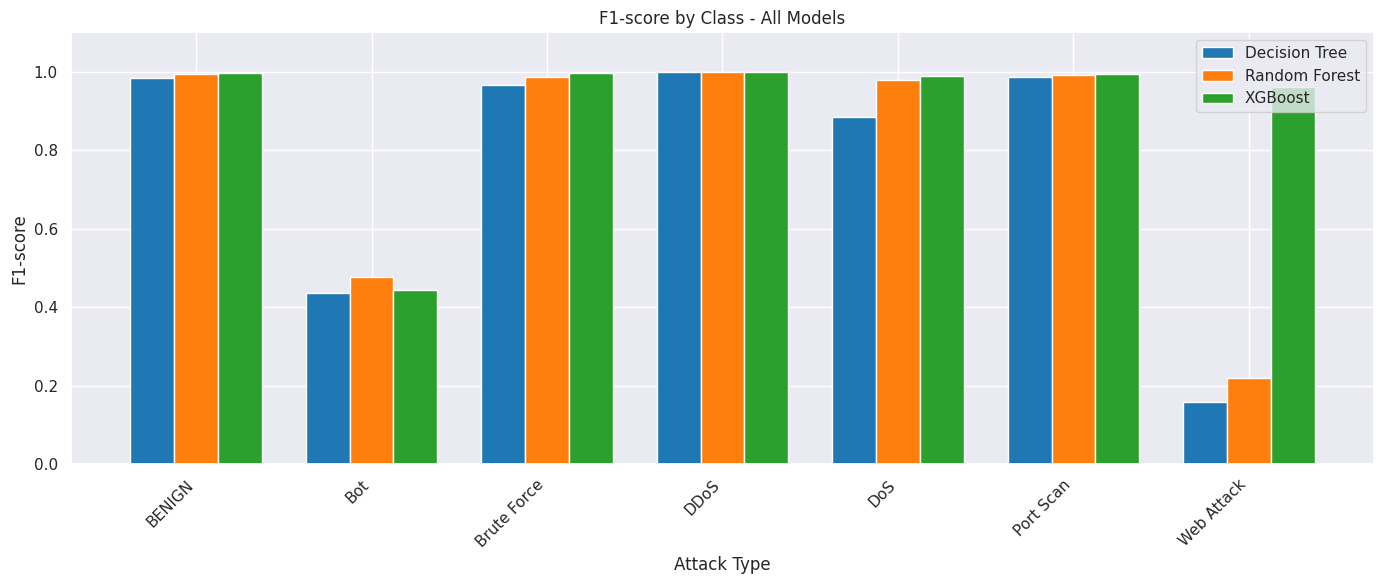

In [64]:
# Plot per-class F1 scores
metrics_to_plot = ['precision', 'recall', 'f1-score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for metric in metrics_to_plot:
    fig, ax = plt.subplots(figsize=(14, 6))
    x = np.arange(len(target_names))
    width = 0.25
    
    for i, (name, results) in enumerate(all_results.items()):
        report = results['classification_report']
        values = [report[cls][metric] for cls in target_names]
        ax.bar(x + i*width, values, width, label=name, color=colors[i])
    
    ax.set_xlabel('Attack Type')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} by Class - All Models')
    ax.set_xticks(x + width)
    ax.set_xticklabels(target_names, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.show()

## 16. Best Model

In [65]:
# Find best model by F1 (macro)
best_name = max(all_results.keys(), key=lambda x: all_results[x]['f1_macro'])
best_results = all_results[best_name]
best_model = trained_models[best_name]

print(f"\nBest Model: {best_name}")
print(f"   Accuracy:      {best_results['accuracy']:.4f}")
print(f"   F1 (macro):    {best_results['f1_macro']:.4f}")
print(f"   F1 (weighted): {best_results['f1_weighted']:.4f}")
if 'pr_auc' in best_results:
    print(f"   PR-AUC:        {best_results['pr_auc']:.4f}")
print(f"   Training Time: {training_times[best_name]:.2f}s")


Best Model: XGBoost
   Accuracy:      0.9959
   F1 (macro):    0.9118
   F1 (weighted): 0.9964
   PR-AUC:        0.9607
   Training Time: 141.58s


## 17. Save Model

In [66]:
# Save best model
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = OUTPUT_DIR / f'cicflowmeter_model_{timestamp}.pkl'
artifacts_path = OUTPUT_DIR / 'cicflowmeter_artifacts.pkl'
results_path = OUTPUT_DIR / f'cicflowmeter_results_{timestamp}.json'

# Model data (includes model + metadata)
model_data = {
    'model': best_model,
    'model_name': best_name,
    'feature_columns': feature_columns,
    'label_mapping': attack_mapping,
    'target_names': target_names,
    'timestamp': timestamp,
    'dataset': 'CIC-IDS-2017',
    'window_size': WINDOW_SIZE,
}
joblib.dump(model_data, model_path)
print(f"Saved model: {model_path}")

# Artifacts (scaler + feature columns)
artifacts = {
    'scaler': scaler,
    'feature_columns': feature_columns,
    'label_mapping': attack_mapping,
    'target_names': target_names,
}
joblib.dump(artifacts, artifacts_path)
print(f"Saved artifacts: {artifacts_path}")

# Results (JSON serializable)
json_results = {
    'best_model': best_name,
    'timestamp': timestamp,
    'train_samples': len(y_train_balanced),
    'val_samples': len(y_val_windowed),
    'test_samples': len(y_test_windowed),
    'n_features': len(feature_columns),
    'n_classes': len(target_names),
    'feature_columns': feature_columns,
    'target_names': target_names,
    'results': {}
}

for name, results in all_results.items():
    json_results['results'][name] = {
        'accuracy': float(results['accuracy']),
        'precision_macro': float(results['precision_macro']),
        'precision_weighted': float(results['precision_weighted']),
        'recall_macro': float(results['recall_macro']),
        'recall_weighted': float(results['recall_weighted']),
        'f1_macro': float(results['f1_macro']),
        'f1_weighted': float(results['f1_weighted']),
        'training_time': float(training_times[name]),
    }
    if 'pr_auc' in results:
        json_results['results'][name]['pr_auc'] = float(results['pr_auc'])

with open(results_path, 'w') as f:
    json.dump(json_results, f, indent=2)
print(f"Saved results: {results_path}")

Saved model: ../data/models/cicflowmeter_model_20260106_160438.pkl
Saved artifacts: ../data/models/cicflowmeter_artifacts.pkl
Saved results: ../data/models/cicflowmeter_results_20260106_160438.json


## 18. Summary

In [67]:
print("\n" + "="*60)
print("                    TRAINING SUMMARY")
print("="*60)

print(f"\n Dataset Statistics:")
print(f"   Total samples:     {len(y):,}")
print(f"   Train samples:     {len(y_train_balanced):,} (after balancing)")
print(f"   Validation samples: {len(y_val_windowed):,}")
print(f"   Test samples:      {len(y_test_windowed):,}")
print(f"   Features:          {len(feature_columns)}")
print(f"   Classes:           {len(target_names)}")

print(f"\n Best Model: {best_name}")
print(f"   Accuracy:      {best_results['accuracy']:.4f}")
print(f"   F1 (macro):    {best_results['f1_macro']:.4f}")
print(f"   F1 (weighted): {best_results['f1_weighted']:.4f}")

print(f"\n Saved Files:")
print(f"   Model:     {model_path}")
print(f"   Artifacts: {artifacts_path}")
print(f"   Results:   {results_path}")

print("\n" + "="*60)
print(" Training pipeline complete!")
print("="*60)


                    TRAINING SUMMARY

 Dataset Statistics:
   Total samples:     2,529,941
   Train samples:     518,848 (after balancing)
   Validation samples: 252,990
   Test samples:      505,985
   Features:          48
   Classes:           7

 Best Model: XGBoost
   Accuracy:      0.9959
   F1 (macro):    0.9118
   F1 (weighted): 0.9964

 Saved Files:
   Model:     ../data/models/cicflowmeter_model_20260106_160438.pkl
   Artifacts: ../data/models/cicflowmeter_artifacts.pkl
   Results:   ../data/models/cicflowmeter_results_20260106_160438.json

 Training pipeline complete!
